# Quick Start

(*This notebook can be found on* [github](https://github.com/NCKU-QFort/Heom.jl/tree/main/docs/src/notebooks))

### Content
 - [Import Heom.jl](#Import-Heom.jl)
 - [System and Bath](#System-and-Bath)
 - [HEOM liouvillian superoperator](#HEOM-liouvillian-superoperator)
 - [Time Evolution](#Time-Evolution)
 - [Stationary State](#Stationary-State)
 - [Multiple Baths](#Multiple-Baths)

### Import Heom.jl
Here are the functions in `Heom.jl` that we will use in this tutorial (Quick Start):

In [2]:
import Heom: Boson_DrudeLorentz_Pade, M_Boson, evolution, SteadyState, getRho, BosonBath

Note that you can also type `using Heom` to import everything you need in `Heom.jl`.

### System and Bath
Let us consider a simple two-level system coupled to a Drude-Lorentz bosonic bath. The system Hamiltonian, $H_{sys}$, and the bath spectral density, $J_D$, are
$$ H_{sys}=\frac{\epsilon \sigma_z}{2} + \frac{\Delta \sigma_x}{2} ~~\text{and}$$  
$$J_{D}(\omega)=\frac{2\lambda W\omega}{W^2+\omega^2},$$

#### System Hamiltonian and initial state
You can construct system hamiltonian, initial state, and coupling operators by standard julia bulit-in types: `Vector`, `SparseVector`, `Matrix`, `SparseMatrix`.

Moreover, it is also convenient to use [QuantumOptics](https://qojulia.org/) framework. It provides many useful functions to create arbitrary quantum states and operators which can be combined in all the expected ways.

Note that `Heom.jl` only accept standard julia bulit-in types. If you use `QuantumOptics` to construct the operators, remember that the matrix (or vector) in standard type are stored in `.data` field of the objects, i.e., `op.data` where `op` is a `QuantumOptics`-type object.  
Thus, you should take it as the inputs of `Heom.jl` for objects in `QuantumOptics` package.

We demonstrate this tutorial by `QuantumOptics`:

In [3]:
import QuantumOptics: SpinBasis, sigmaz, sigmax, ⊗, Ket, Bra

In [4]:
basis = SpinBasis(1//2)

# The system Hamiltonian
ϵ = 0.5 # energy of 2-level system
Δ = 1.0 # tunneling term

Hsys = 0.5 * ϵ * sigmaz(basis) + 0.5 * Δ * sigmax(basis)

# System initial state
ρ0 = Ket(basis, [1, 0]) ⊗ Bra(basis, [1, 0]);

#### Bath Properties
Now, we demonstrate how to describe the bath using the built-in implementation of $J_D(\omega)$ under Pade expansion by calling [`Boson_DrudeLorentz_Pade`](@ref)

In [5]:
λ = 0.1  # coupling strength
W = 0.5  # cut-off frequency
T = 0.5  # temperature

# system-bath coupling operator
Q = sigmaz(basis);

# Number of expansion terms to retain:
N = 2

# Padé expansion:
## Remember to give the operator in Standard matrix (AbstractMatrix) type
## That is, if using QuantumOptics package, give system coupling operator as Q.data
bath = Boson_DrudeLorentz_Pade(Q.data, λ, W, T, N);

For other different expansions of the different spectral density correlation functions, please refer to [Bosonic Bath](@ref) and [Fermionic Bath](@ref).

### HEOM liouvillian superoperator
For bosonic bath, we can construct the Heom liouvillian superoperator matrix by calling [`M_Boson`](@ref)

In [6]:
# maximum tier of hierarchy
tier = 5

# Remember to give the operator in Standard matrix (AbstractMatrix) type
# That is, if using QuantumOptics package, give system hamiltonian as Hsys.data
L = M_Boson(Hsys.data, tier, bath; verbose=false);

To learn more about the Heom liouvillian superoperator matrix (including other types: `M_Fermion`, `M_Boson_Fermion`), please refer to [HEOM Matrix](@ref).

### Time Evolution
Next, we can calculate the time evolution for the entire auxiliary density operators (ADOs) by calling [`evolution`](@ref)

In [7]:
tlist = 0:0.2:50
ados_list = evolution(L, ρ0.data, tlist; verbose=false);

 11.475551 seconds (6.03 M allocations: 343.426 MiB, 6.76% gc time, 94.97% compilation time)


To learn more about `evolution`, please refer to [Auxiliary Density Operators](@ref).

### Stationary State
We can also solve the stationary state of the auxiliary density operators (ADOs) by calling [`SteadyState`](@ref).

In [8]:
ados_steady = SteadyState(L; verbose=false);

  1.437269 seconds (486.90 k allocations: 26.944 MiB, 40.65% gc time, 59.19% compilation time: 86% of which was recompilation)


To learn more about `SteadyState`, please refer to [Auxiliary Density Operators](@ref).

#### Calculate population and coherence
We can now compare the results obtained from `evolution` and `SteadyState`:

In [9]:
import LinearAlgebra: tr  # import trace function

In [10]:
# Define the operators that measure the populations of the two
# system states:
P00 = Ket(basis, [1, 0]) ⊗ Bra(basis, [1, 0])
P11 = Ket(basis, [0, 1]) ⊗ Bra(basis, [0, 1])

# Define the operator that measures the 0, 1 element of density matrix
# (corresponding to coherence):
P01 = Ket(basis, [1, 0]) ⊗ Bra(basis, [0, 1]);

To obtain the reduced density operator, one can either access the first element of auxiliary density operator (`ADOs`) or call [`getRho`](@ref):

In [11]:
# for steady state
ρs = ados_steady[1]  # 1 represents the 1st auxiliary density operator (reduce state)
p00_s = real(tr(P00.data * ρs))
p01_s = real(tr(P01.data * ρs))

# for time evolution
p00_e = []
p01_e = []
for i in 1:length(tlist)
    ρe = ados_list[i][1]
    push!(p00_e, real(tr(P00.data * ρe)))
    push!(p01_e, real(tr(P01.data * ρe)))
end

One of the great features of `Heom.jl` is that we allow users to not only considering the density operator of the reduced
state but also easily take high-order terms into account without struggling in finding the indices (see [Hierarchy Dictionary](@ref) for more details).

#### Plot the results

In [12]:
using Plots
Plots.scalefontsizes(1.5)

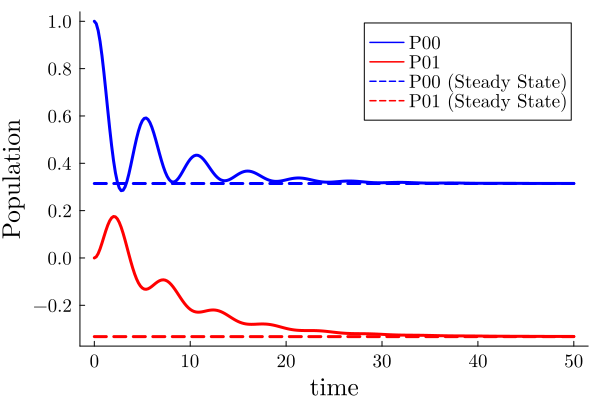

In [13]:
p = plot(
    tlist, 
    [
        p00_e,
        p01_e,
        ones(length(tlist)) .* p00_s, 
        ones(length(tlist)) .* p01_s,
    ],
    label=["P00" "P01" "P00 (Steady State)" "P01 (Steady State)"],
    linecolor=[ :blue   :red :blue  :red],
    linestyle=[:solid :solid :dash :dash],
    xlabel="time",
    ylabel="Population",
    fontfamily="Computer Modern",
    linewidth=3, 
    grid=false,
    dpi=300 
)

p

### Multiple Baths
`Heom.jl` also supports for system to interact with multiple baths.  
All you need to do is to provide a list of baths instead of a single bath

In [14]:
# The system Hamiltonian
Hsys = [
    0.25 1.50 2.50;
    1.50 0.75 3.50;
    2.50 3.50 1.25
]

# System initial state
ρ0 = [
    1 0 0;
    0 0 0;
    0 0 0
];

# Construct one bath for each system state:
## note that `BosonBath[]` make the list created in type: Vector{BosonBath}
baths = BosonBath[]
for i in 1:3
    # system-bath coupling operator: |i><i|
    Q = zeros(3, 3)
    Q[i, i] = 1
    
    push!(baths, Boson_DrudeLorentz_Pade(Q, λ, W, T, N))
end

In [15]:
L = M_Boson(Hsys, tier, baths; verbose=false);

In [16]:
tlist = 0:0.025:5
ados_list = evolution(L, ρ0, tlist; verbose=false);

  2.727398 seconds (93.32 k allocations: 539.333 MiB, 49.21% gc time, 11.03% compilation time: 100% of which was recompilation)


In [17]:
# Projector for each system state:
P00 = [1 0 0; 0 0 0; 0 0 0]
P11 = [0 0 0; 0 1 0; 0 0 0]
P22 = [0 0 0; 0 0 0; 0 0 1]

# calculate population for each system state:
p0 = []
p1 = []
p2 = []
for ados in ados_list
    ρ = getRho(ados)  # same as ados[1]
    push!(p0, real(tr(P00 * ρ)))
    push!(p1, real(tr(P11 * ρ)))
    push!(p2, real(tr(P22 * ρ)))
end

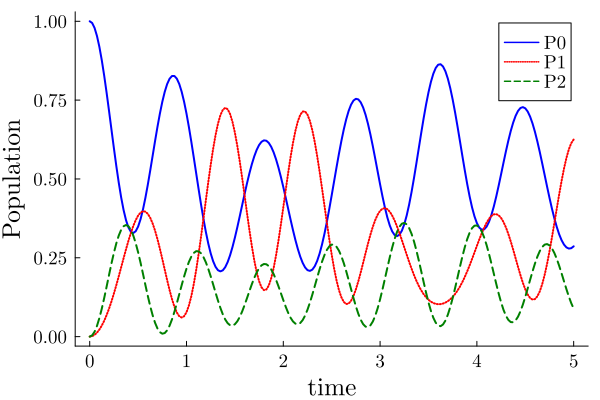

In [18]:
p = plot(
    tlist, 
    [p0, p1, p2],
    label=["P0" "P1" "P2"],
    linecolor=[ :blue :red :green],
    linestyle=[:solid :dot  :dash],
    xlabel="time",
    ylabel="Population",
    fontfamily="Computer Modern",
    linewidth=2, 
    grid=false,
    dpi=300 
)

p

Note that this example can also be found in [qutip documentation](https://qutip.org/docs/latest/guide/heom/bosonic.html).